# Algoritmo de Saliency map para Torch aplicada a imágenes de cerebros con diferentes diagnósticos de Alzheimer.

In [12]:
import sys
def in_colab():
    "Check if the code is running in Google Colaboratory"
    return 'google.colab' in sys.modules

In [13]:
if in_colab():
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Empezamos con las importaciones:**

In [17]:

#IMPORTS

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image

#Using VGG-19 pretrained model for image classification

model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

# Modelo

**Vamos a usar ganchos para obtener los mapas de activación y los gradientes de la capa y el tensor deseados, respectivamente. Para este tutorial vamos a tomar los mapas de activación de la capa 4 de ResNet50 y gradientes con respecto al tensor de salida de la misma**.

In [27]:
# Opening the image
img = Image.open('/content/drive/MyDrive/Imagenes Cerebro/Imagenes modelo/NonDemented/13116.jpg') 

**Declaramos la instancia de Modelo.**

**Leemos la imagen.**

In [28]:
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

**Compute Gradient Class Activation Maps.**

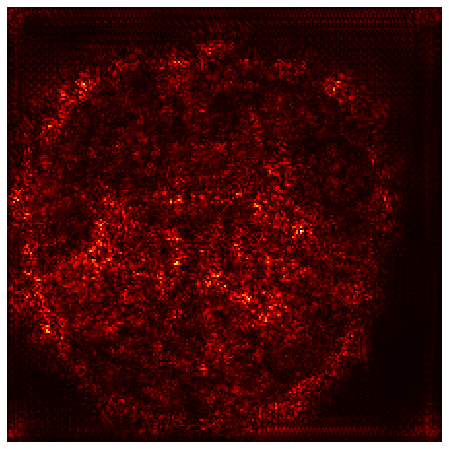

In [29]:
# preprocess the image
X = preprocess(img)

# we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

scores = model(X)

# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()